In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (20,10)

# Preparing Kolding Data

In [38]:
# Load Data
path = r'../data/kolding/'
files = glob.glob(path + "/*.csv")

dfs = []

for file in files:
    df = pd.read_csv(file, index_col=None, header=0)
    dfs.append(df)

kld = pd.concat(dfs, axis=0, ignore_index=True)
kld.Datetime = pd.to_datetime(kld.Datetime)
kld = kld.groupby('Datetime').sum()

### Handling Missing Values

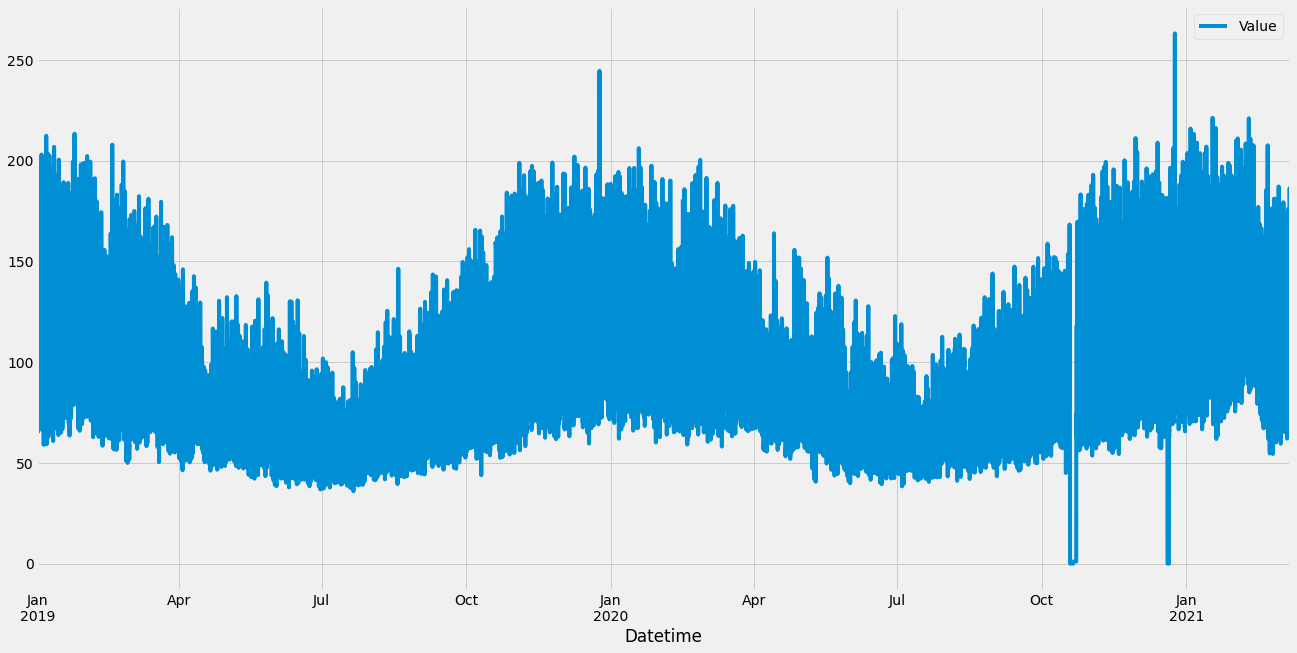

In [4]:
kld.plot()
plt.show()

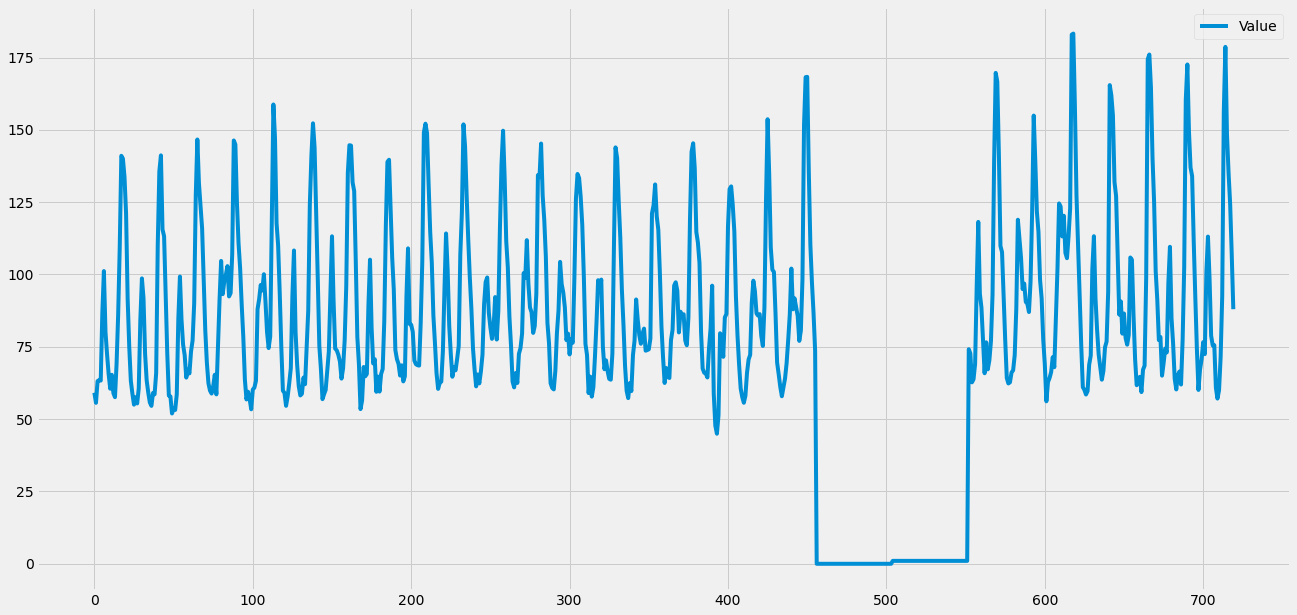

In [5]:
pd.read_csv('../data/kolding/7_kld_202010.csv', index_col=None, header=0).plot()
plt.show()

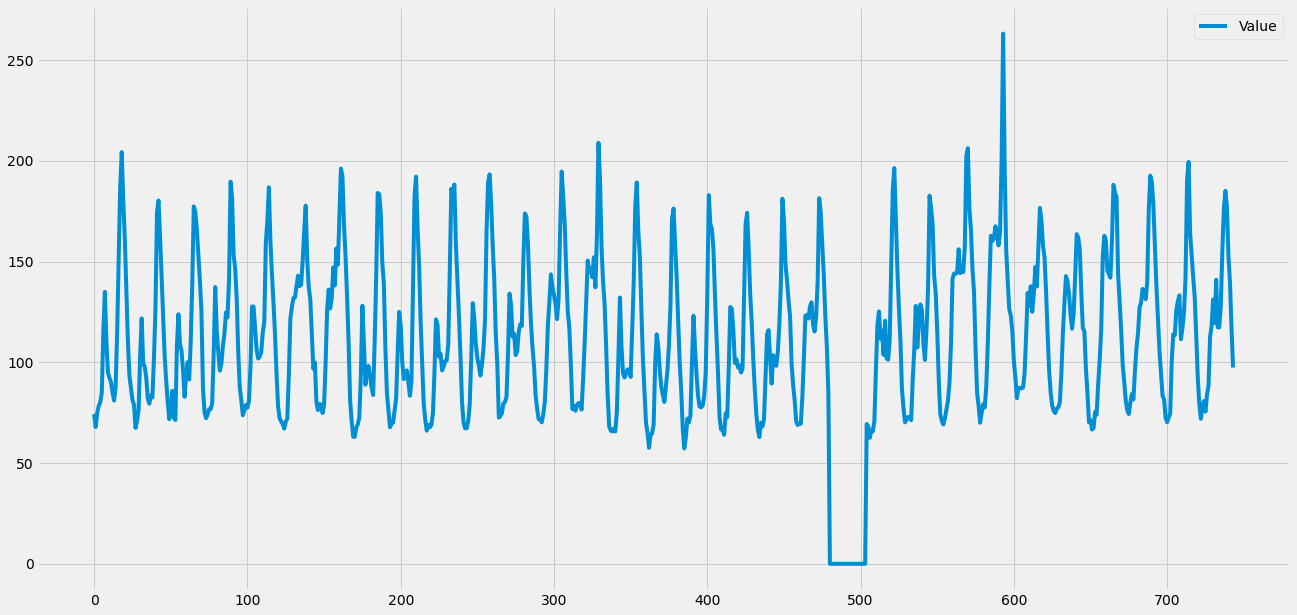

In [6]:
pd.read_csv('../data/kolding/9_kld_202012.csv', index_col=None, header=0).plot()
plt.show()

In [11]:
kld[kld.Value < 10]['Value'].unique()

array([0.  , 1.01, 1.  , 1.02])

In [63]:
np.unique(kld[kld['Value'].isna() == True].index.date)

array([datetime.date(2020, 10, 19), datetime.date(2020, 10, 20),
       datetime.date(2020, 10, 21), datetime.date(2020, 10, 22),
       datetime.date(2020, 12, 20)], dtype=object)

The plots show two time periods where there is missing data. In the October plot the missing data runs over a 4-day period; one day showing zeros and the next day shows a constant low value of 1.01.  
The december data shows a constant 0 aswell.

In [39]:
kld.replace(1, np.nan,inplace=True)
kld.replace(1.01, np.nan, inplace=True)
kld.replace(1.02, np.nan, inplace=True)
kld.replace(0, np.nan, inplace=True)

In [40]:
print(kld[kld.Value.isna()].index.day.unique())
print(kld[kld.Value.isna()].index.month.unique())

Int64Index([19, 20, 21, 22], dtype='int64', name='Datetime')
Int64Index([10, 12], dtype='int64', name='Datetime')


In [41]:
kld[kld.index == dt.datetime(2020,10,19)].index.dayofweek

Int64Index([0], dtype='int64', name='Datetime')

In [42]:
kld[kld.index == dt.datetime(2019,10,19)].index.dayofweek

Int64Index([5], dtype='int64', name='Datetime')

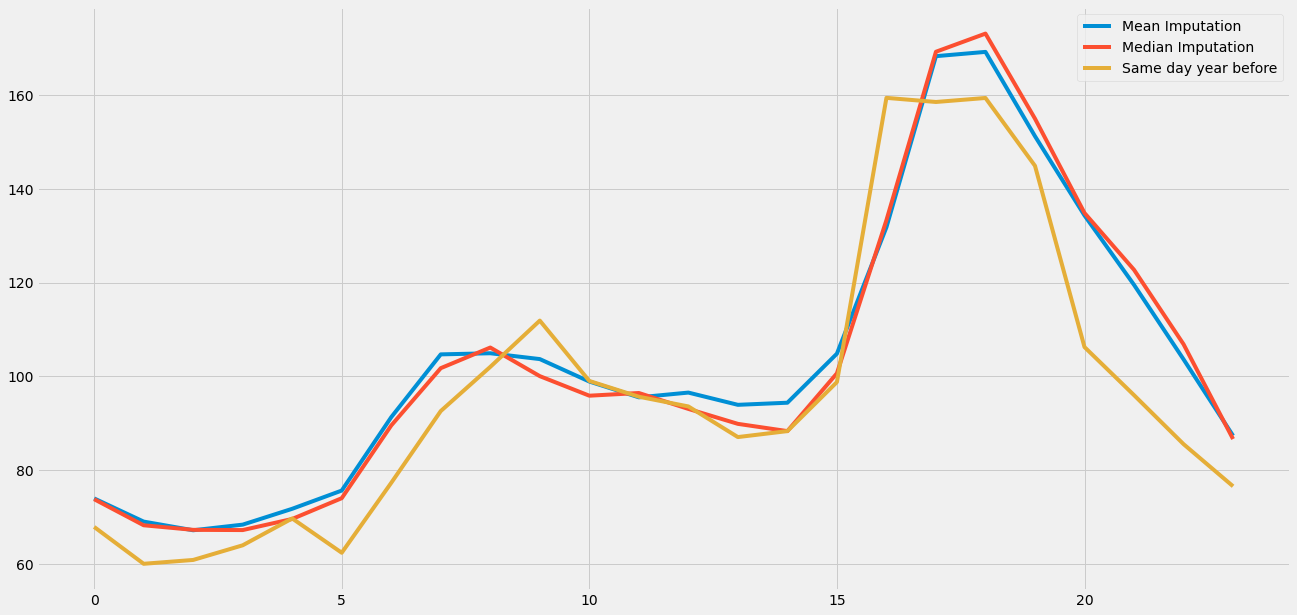

In [43]:
mn = []
md = []
sameday = kld[(kld.index >= dt.datetime(2019,10,19)) & (kld.index < dt.datetime(2019,10,20))].Value.tolist()
for t in range(24):
    mn.append(kld[((kld.index.dayofweek == 0) | (kld.index.dayofweek == 5)) & (kld.index.hour == t) & (kld.index.quarter == 4)].mean()[0])
    md.append(kld[((kld.index.dayofweek == 0) | (kld.index.dayofweek == 5)) & (kld.index.hour == t) & (kld.index.quarter == 4)].median()[0])
    

plt.plot(mn, label='Mean Imputation')
plt.plot(md, label='Median Imputation')
plt.plot(sameday, label='Same day year before')
plt.legend()
plt.show()

In [82]:
pd.DataFrame({'median':md, 'mean':mn, 'sameday':sameday}).corr()

,median,mean,sameday
median,1.000000,0.997103,0.931891
mean,0.997103,1.000000,0.939256
sameday,0.931891,0.939256,1.000000


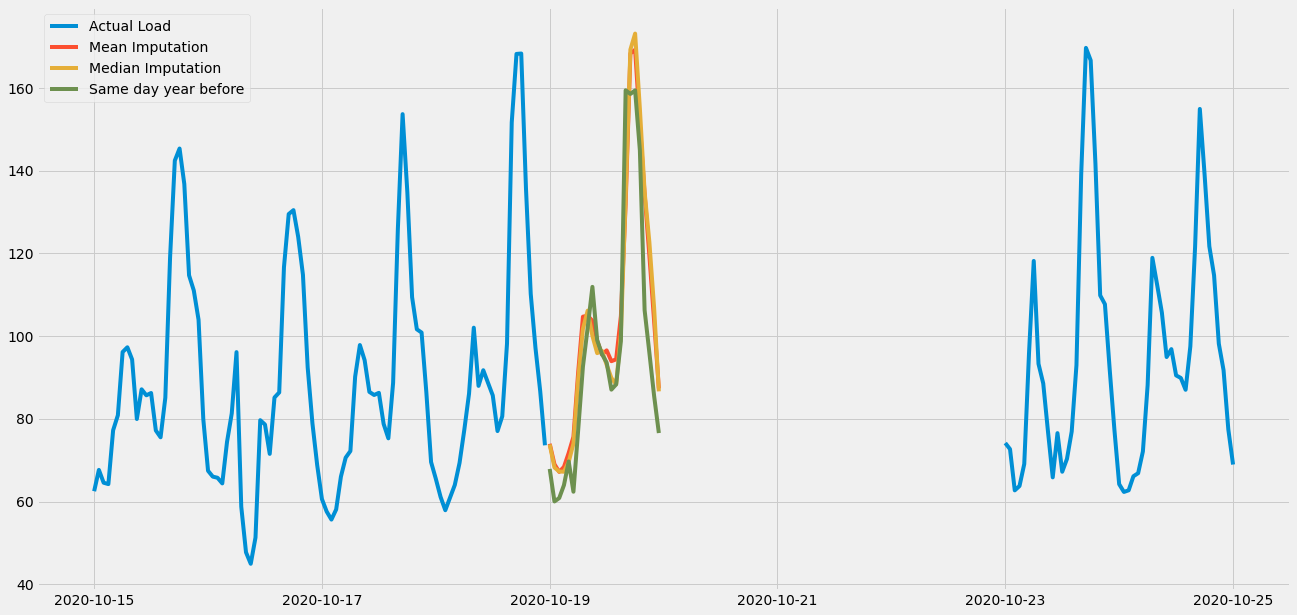

In [62]:
x = pd.date_range('2020-10-19', '2020-10-20', freq='H')
octkld = kld[(kld.index >= dt.datetime(2020,10,15)) & (kld.index <= dt.datetime(2020,10,25))]

plt.plot(octkld, label='Actual Load')
plt.plot(x[:-1], mn, label='Mean Imputation')
plt.plot(x[:-1], md, label='Median Imputation')
plt.plot(x[:-1], sameday, label='Same day year before')
plt.legend()
plt.show()

In [68]:
from sklearn.preprocessing import MinMaxScaler

In [106]:
T = 6
HORIZON = 1
valid_date = dt.datetime(2020,8,19)
end_date = dt.datetime(2020,10,19)

In [81]:
data = kld[kld.index < dt.datetime(2020,10,19)]

In [82]:
train = kld.copy()[kld.index < valid_date]

In [83]:
scaler = MinMaxScaler()
train['Value'] = scaler.fit_transform(train)

In [84]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['Value'].shift(-1, freq='H')
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['Value'].shift(T-t, freq='H')
y_col = 'y_t+1'
X_cols = ['load_t-5',
         'load_t-4',
         'load_t-3',
         'load_t-2',
         'load_t-1',
         'load_t']
train_shifted.columns = ['load_original'] + [y_col] + X_cols

In [85]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head()

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
Datetime,,,,,,,,
2019-01-01 05:00:00,0.139402,0.148023,0.385397,0.320023,0.289821,0.236975,0.186607,0.139402
2019-01-01 06:00:00,0.148023,0.162377,0.320023,0.289821,0.236975,0.186607,0.139402,0.148023
2019-01-01 07:00:00,0.162377,0.198171,0.289821,0.236975,0.186607,0.139402,0.148023,0.162377
2019-01-01 08:00:00,0.198171,0.227726,0.236975,0.186607,0.139402,0.148023,0.162377,0.198171
2019-01-01 09:00:00,0.227726,0.333720,0.186607,0.139402,0.148023,0.162377,0.198171,0.227726


In [89]:
y_train = train_shifted[y_col].values
X_train = train_shifted[X_cols].values

X_train = X_train.reshape(X_train.shape[0], T, 1)

print(y_train.shape)
print(X_train.shape)

(14298,)
(14298, 6, 1)


In [109]:
val = kld.copy()[(kld.index >= valid_date) & (kld.index < end_date)]
val['Value'] = scaler.fit_transform(val)
val_shifted = val.copy()
val_shifted['y_t+1'] = val_shifted['Value'].shift(-1, freq='H')
for t in range(1, T+1):
    val_shifted[str(T-t)] = val_shifted['Value'].shift(T-t, freq='H')
y_col = 'y_t+1'
X_cols = ['load_t-5',
         'load_t-4',
         'load_t-3',
         'load_t-2',
         'load_t-1',
         'load_t']
val_shifted.columns = ['load_original'] + [y_col] + X_cols

val_shifted = val_shifted.dropna(how='any')
val_shifted.head()

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
Datetime,,,,,,,,
2020-08-19 05:00:00,0.218987,0.332682,0.080946,0.090174,0.153920,0.115232,0.100434,0.218987
2020-08-19 06:00:00,0.332682,0.118281,0.090174,0.153920,0.115232,0.100434,0.218987,0.332682
2020-08-19 07:00:00,0.118281,0.052326,0.153920,0.115232,0.100434,0.218987,0.332682,0.118281
2020-08-19 08:00:00,0.052326,0.034542,0.115232,0.100434,0.218987,0.332682,0.118281,0.052326
2020-08-19 09:00:00,0.034542,0.014182,0.100434,0.218987,0.332682,0.118281,0.052326,0.034542


In [110]:
y_val = val_shifted[y_col].values
X_val = val_shifted[X_cols].values

X_val = X_val.reshape(X_val.shape[0], T, 1)

print(y_val.shape)
print(X_val.shape)

(1458,)
(1458, 6, 1)


In [93]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [94]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 25

In [95]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))
model.compile(optimizer='RMSprop', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 120       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [96]:
GRU_ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [98]:
hist = model.fit(X_train,
                y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(X_val, y_val),
                callbacks=[GRU_ES],
                verbose=1)

Epoch 1/25
447/447 [==============================] - 4s 4ms/step - loss: 0.0143 - val_loss: 0.0123
Epoch 2/25
447/447 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0104
Epoch 3/25
447/447 [==============================] - 1s 3ms/step - loss: 0.0034 - val_loss: 0.0103
Epoch 4/25
447/447 [==============================] - 1s 3ms/step - loss: 0.0032 - val_loss: 0.0102
Epoch 5/25
447/447 [==============================] - 1s 3ms/step - loss: 0.0033 - val_loss: 0.0102
Epoch 6/25
447/447 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0100
Epoch 7/25
447/447 [==============================] - 1s 3ms/step - loss: 0.0033 - val_loss: 0.0100
Epoch 8/25
447/447 [==============================] - 1s 3ms/step - loss: 0.0033 - val_loss: 0.0099
Epoch 9/25
447/447 [==============================] - 1s 3ms/step - loss: 0.0032 - val_loss: 0.0102
Epoch 10/25
447/447 [==============================] - 1s 3ms/step - loss: 0.0033 - val_loss: 0.0100

In [111]:
preds = model.predict(X_val)

In [112]:
eval_data = pd.DataFrame(preds, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_data['Datetime'] = val_shifted.index
eval_data = pd.melt(eval_data, id_vars='Datetime', value_name='Prediction', var_name='H')
eval_data['Actual'] = np.transpose(y_val).ravel()
eval_data[['Prediction','Actual']] = scaler.inverse_transform(eval_data[['Prediction','Actual']])
eval_data.head()

,Datetime,H,Prediction,Actual
0,2020-08-19 05:00:00,t+1,79.018649,84.936
1,2020-08-19 06:00:00,t+1,91.092628,58.147
2,2020-08-19 07:00:00,t+1,47.710319,49.906
3,2020-08-19 08:00:00,t+1,47.650561,47.684
4,2020-08-19 09:00:00,t+1,48.340976,45.140


In [113]:
def mape(pred, true):
    return ((pred - true).abs() / true).mean()

1-mape(eval_data['Prediction'], eval_data['Actual'])

0.9060483478917366

# Preparing Strib Data

In [2]:
# Load Data
path = r'../data/strib/'
files = glob.glob(path + "/*.csv")

dfs = []

for file in files:
    df = pd.read_csv(file, index_col=None, header=0)
    dfs.append(df)

stb = pd.concat(dfs, axis=0, ignore_index=True)
stb.Datetime = pd.to_datetime(stb.Datetime)
stb = stb.groupby('Datetime').sum()

## Handling Missing Values

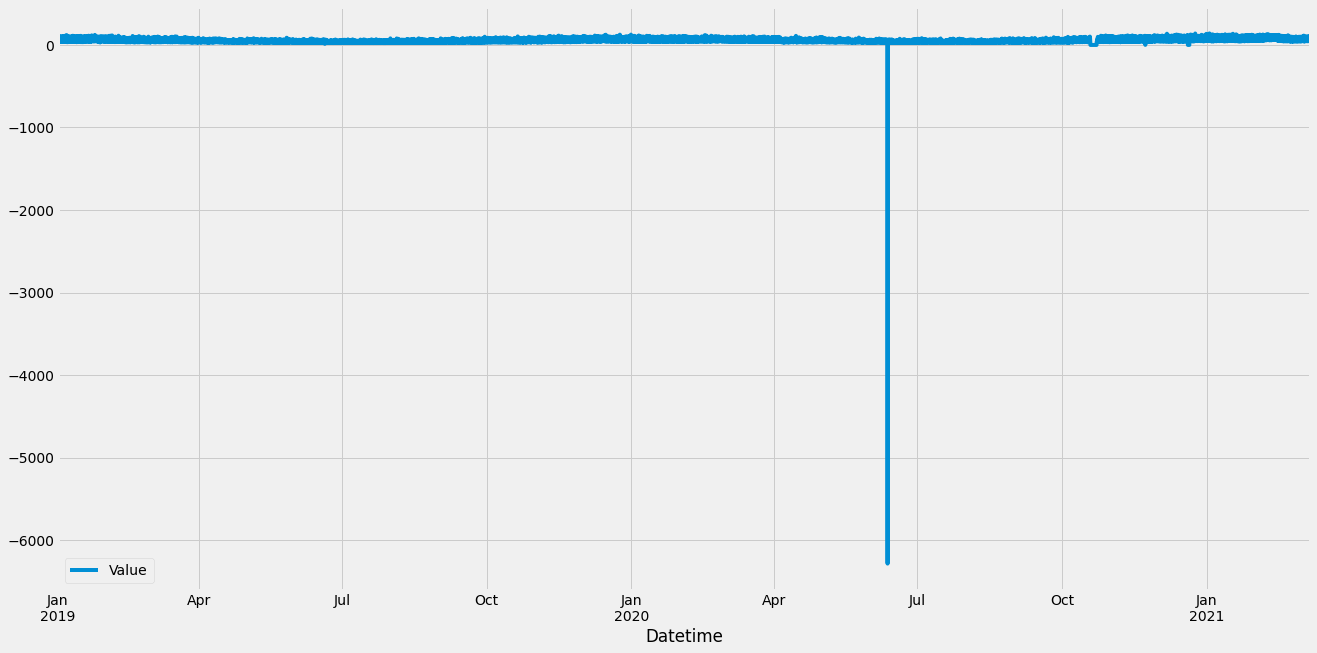

In [4]:
stb.plot()
plt.show()

Large negative values are a result of "sick" meters or meter resetting.

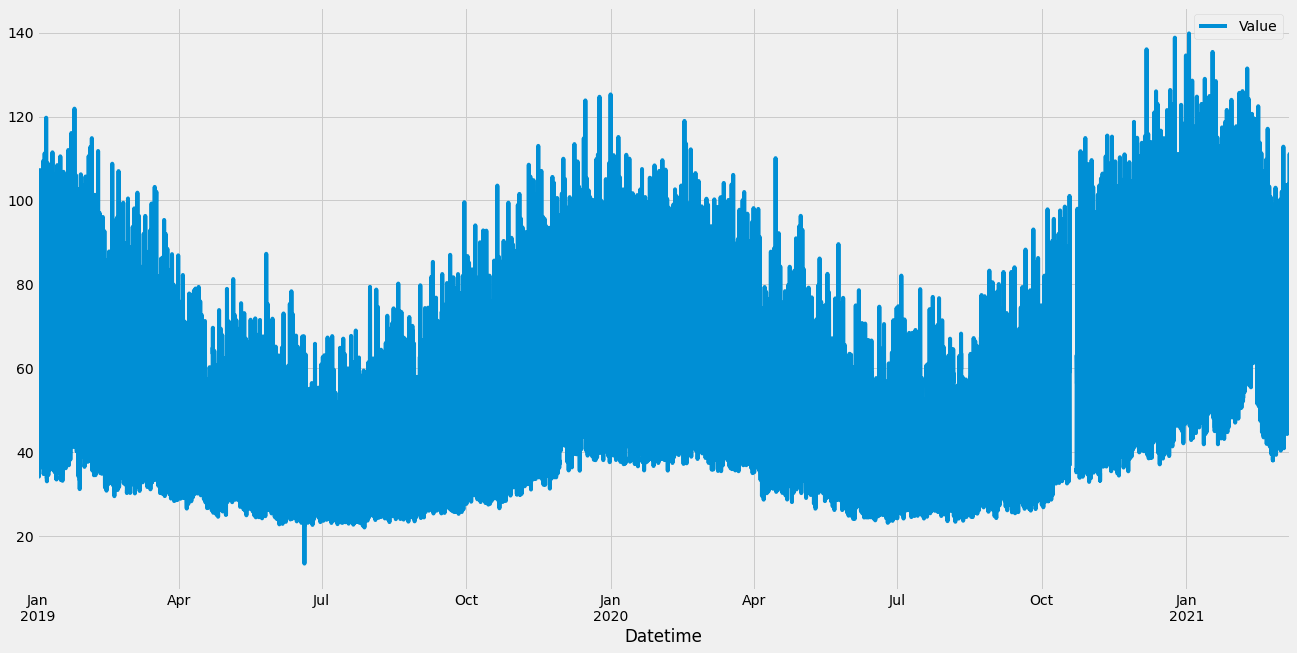

In [14]:
nans = stb[stb.Value < 10]['Value'].unique()

for nan in nans:
    stb.replace(nan, np.nan, inplace=True)

stb.plot()
plt.show()

In [27]:
np.unique(stb[stb['Value'].isna() == True].index.date)

array([datetime.date(2020, 6, 12), datetime.date(2020, 10, 19),
       datetime.date(2020, 10, 20), datetime.date(2020, 10, 21),
       datetime.date(2020, 10, 22), datetime.date(2020, 11, 22),
       datetime.date(2020, 12, 20)], dtype=object)

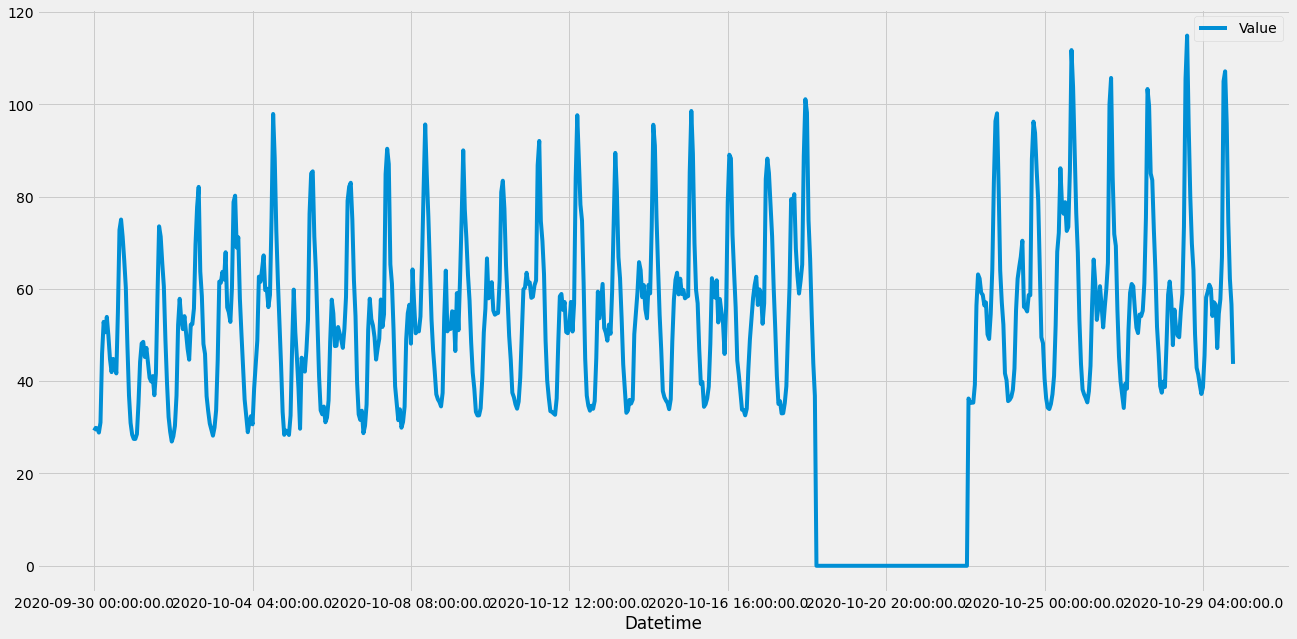

In [31]:
pd.read_csv('../data/strib/7_stb_202010.csv', index_col=None, header=0).groupby('Datetime').sum().plot()
plt.show()

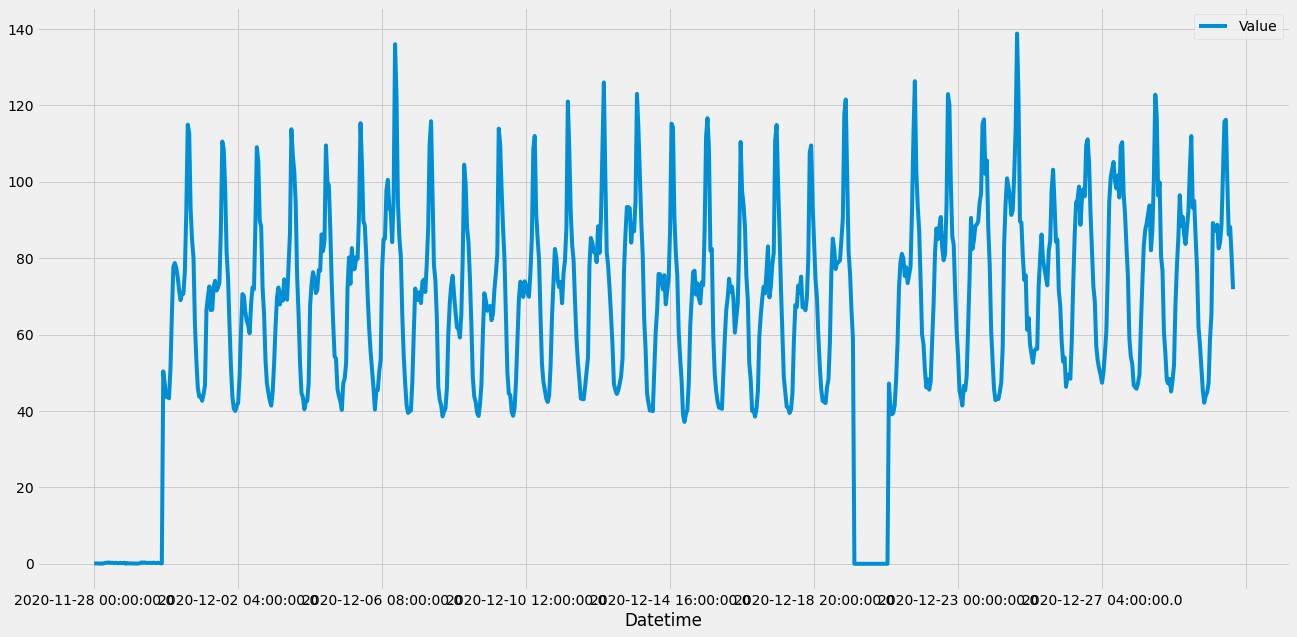

In [32]:
pd.read_csv('../data/strib/9_stb_202012.csv', index_col=None, header=0).groupby('Datetime').sum().plot()
plt.show()

### Introducing Weather Data

In [33]:
# Load Weather Data
weather = pd.read_csv('../data/weather_features.csv', header=0)
weather.Datetime = pd.to_datetime(weather.Datetime)
weather = weather.set_index('Datetime').sort_index()
#weather = weather[weather.index <= kld.index.max()]

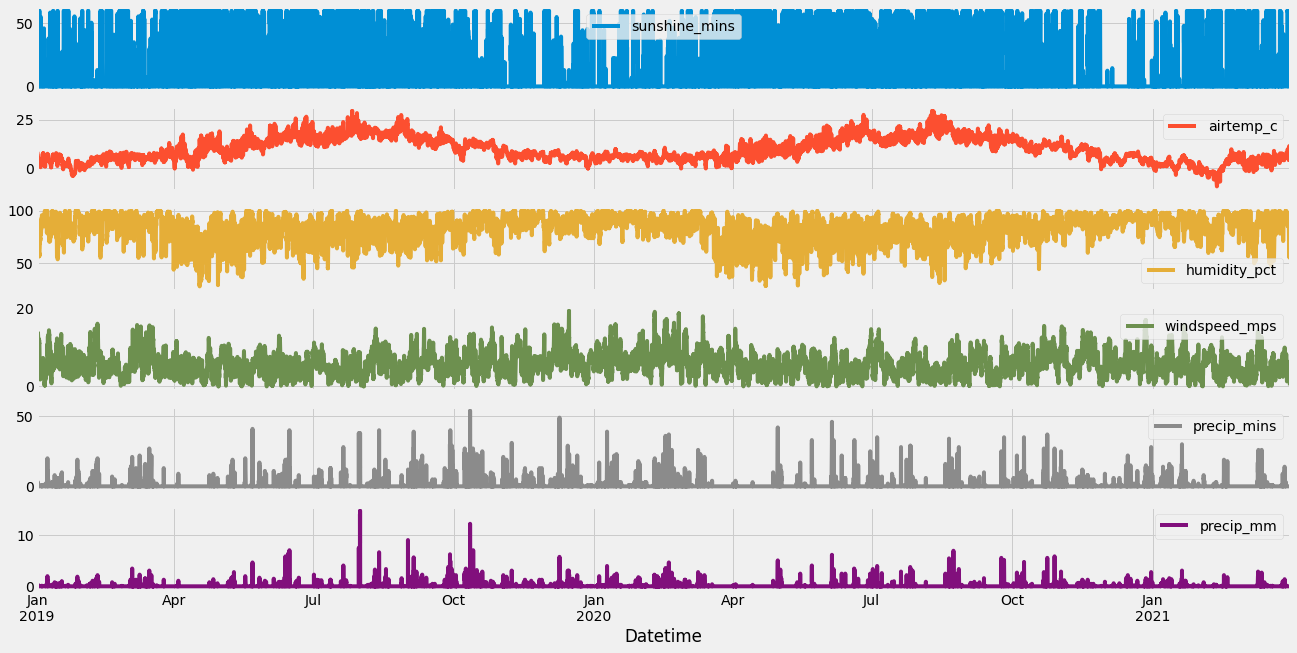

In [35]:
weather.plot(subplots=True)
plt.show()

In [6]:
kld.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19152 entries, 2019-01-01 00:00:00 to 2021-03-07 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   19152 non-null  float64
dtypes: float64(1)
memory usage: 299.2 KB


In [7]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19704 entries, 2019-01-01 00:00:00 to 2021-03-31 23:00:00
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sunshine_mins  19704 non-null  float64
 1   airtemp_c      19704 non-null  float64
 2   humidity_pct   19704 non-null  float64
 3   windspeed_mps  19704 non-null  float64
 4   precip_mins    19704 non-null  float64
 5   precip_mm      19704 non-null  float64
dtypes: float64(6)
memory usage: 1.1 MB


In [8]:
data = pd.merge(kld, weather, left_index=True, right_index=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19152 entries, 2019-01-01 00:00:00 to 2021-03-07 23:00:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Value          19152 non-null  float64
 1   sunshine_mins  19152 non-null  float64
 2   airtemp_c      19152 non-null  float64
 3   humidity_pct   19152 non-null  float64
 4   windspeed_mps  19152 non-null  float64
 5   precip_mins    19152 non-null  float64
 6   precip_mm      19152 non-null  float64
dtypes: float64(7)
memory usage: 1.2 MB


In [13]:
24*365*2 + 24*31 + 24*28 + 24*7 + 24*1

19128